In [1]:
%matplotlib inline

In [2]:
from glob import glob
import uproot3 as uproot
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
columns = [
    "initial_track_chi2",
    "initial_track_cx",
    "initial_track_mx",
    "initial_track_cy",
    "initial_track_my",
    "initial_track_residual_x0",
    "initial_track_residual_x1",
    "initial_track_residual_x2",
    "initial_track_residual_y0",
    "initial_track_residual_y1",
    "initial_track_residual_y2",
    "x0",
    "x1",
    "x2",
    "y0",
    "y1",
    "y2",
    "z0",
    "z1",
    "z2",
    "x0_local",
    "x1_local",
    "x2_local",
    "y0_local",
    "y1_local",
    "y2_local",
    "module0",
    "module1",
    "module2",
    "initial_track_residual_x0_local",
    "initial_track_residual_x1_local",
    "initial_track_residual_x2_local",
    "initial_track_residual_y0_local",
    "initial_track_residual_y1_local",
    "initial_track_residual_y2_local",
    "sigma_x0",
    "sigma_x1",
    "sigma_x2",
    "sigma_y0",
    "sigma_y1",
    "sigma_y2",
    "rho0",
    "rho1",
    "rho2",
    "sigma_x0_local",
    "sigma_x1_local",
    "sigma_x2_local",
    "sigma_y0_local",
    "sigma_y1_local",
    "sigma_y2_local",
    "rho0_local",
    "rho1_local",
    "rho2_local",
]

In [5]:
def convert(runfiles, columns):

    df_ = [uproot.open(f"{input_data}") for input_data in runfiles]

    data = pd.concat([
        df["spfit"].pandas.df(columns, entrystop=None, flatten=True) 
        for df in df_
    ], axis=0)
    del df_
    
    # Required because of the way we define our coordinate systems
    data["x0_local"] += 0
    data["x1_local"] += -5
    data["x2_local"] += 5
    data["y0_local"] += 0
    data["y1_local"] += 0
    data["y2_local"] += 0

    # Sanitize data
    data[["module0", "module1", "module2"]] = data[["module0", "module1", "module2"]].astype(int)
    data = data[data.initial_track_chi2 < 10]
    
    return data



In [6]:
study_it0 = glob("/home/mapr/projects/faser-alignment/Faser-Physics-003446_iteration0/Faser-Physics-003446-0000?/trackerspfit.root")
study_it0 = convert(study_it0, columns)

study_it1 = glob("/home/mapr/projects/faser-alignment/Faser-Physics-003446_iteration1.angle_test/Faser-Physics-003446-0000?/trackerspfit.root")
study_it1 = convert(study_it1, columns)

In [7]:
from alignment.monitoring import plot_chi2, plot_hit_position_per_module, plot_residual_per_module, plot_residual_per_layer

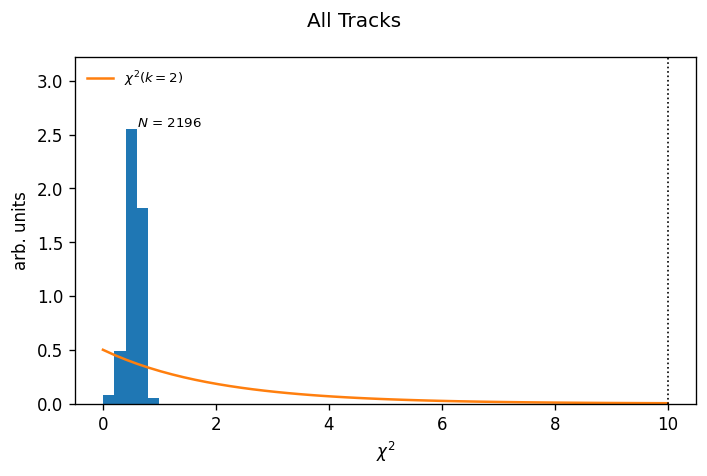

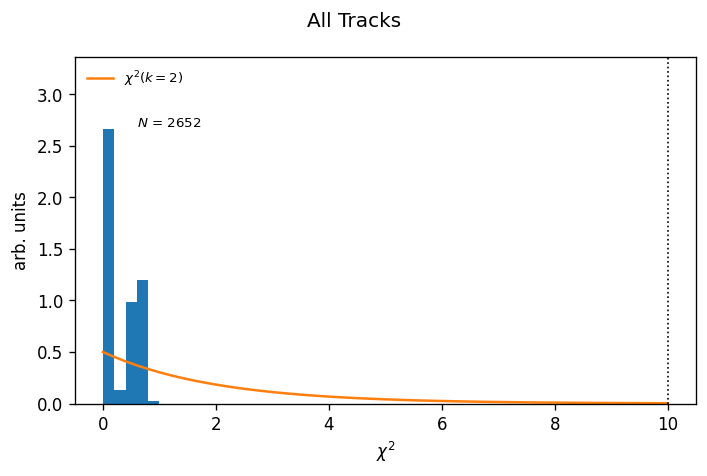

In [8]:
plot_chi2(study_it0, 10, None)
plot_chi2(study_it1, 10, None)

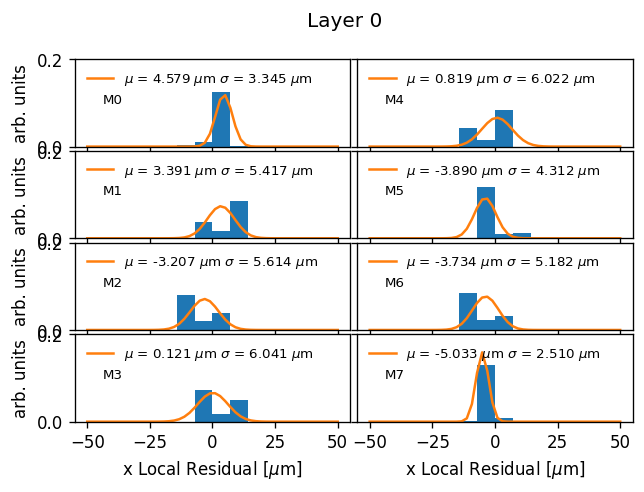

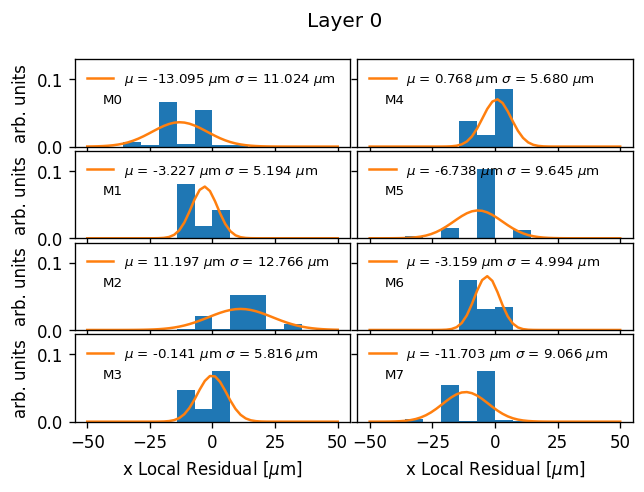

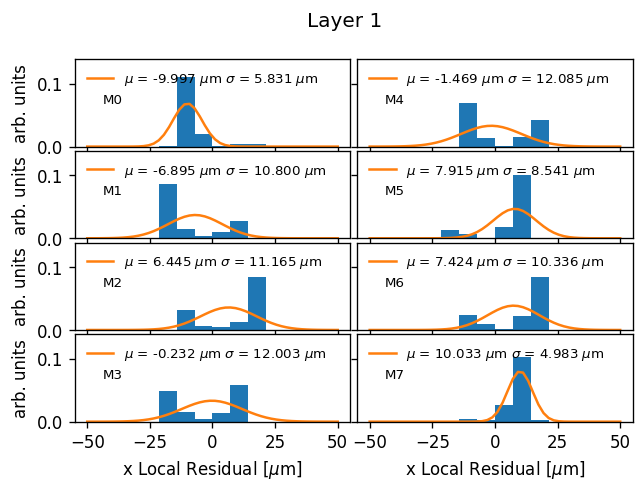

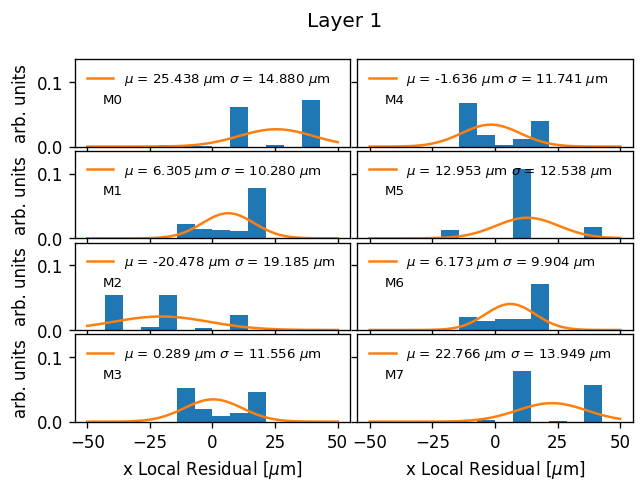

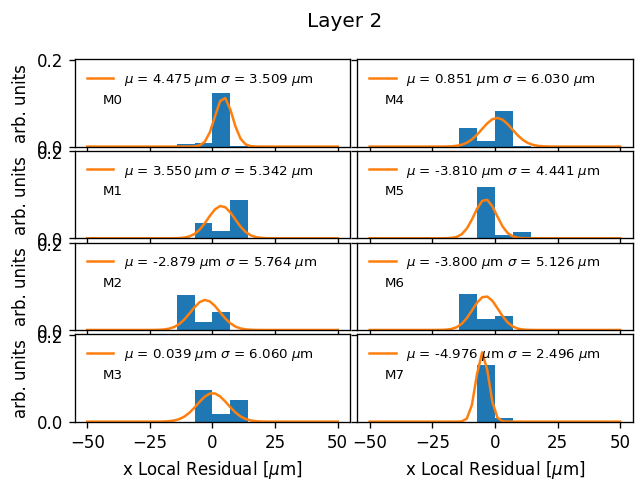

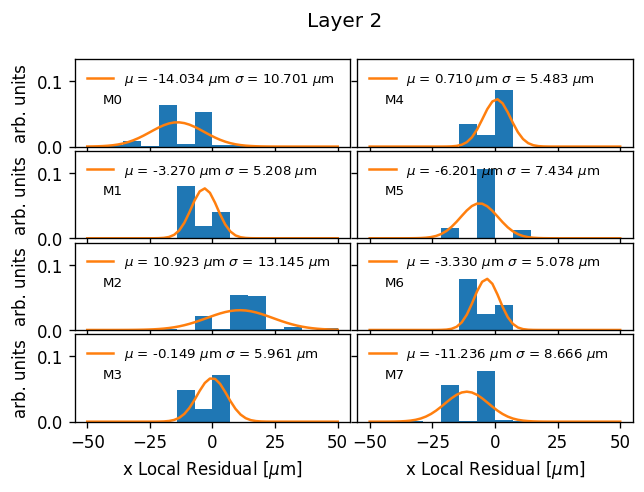

In [10]:
for L in range(3):
    plot_residual_per_module(study_it0, L, "x", None)
    plot_residual_per_module(study_it1, L, "x", None)

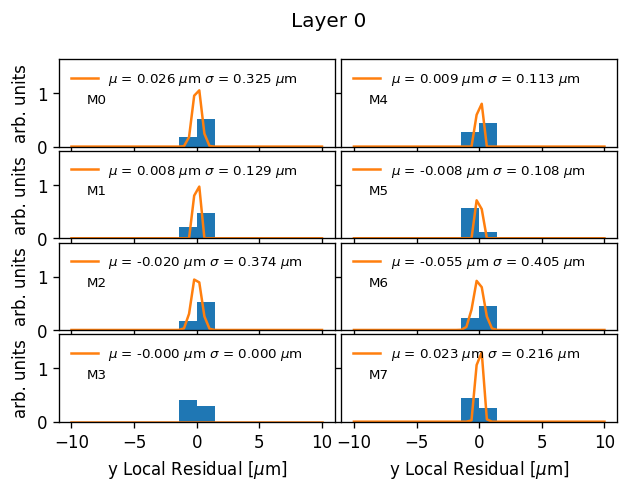

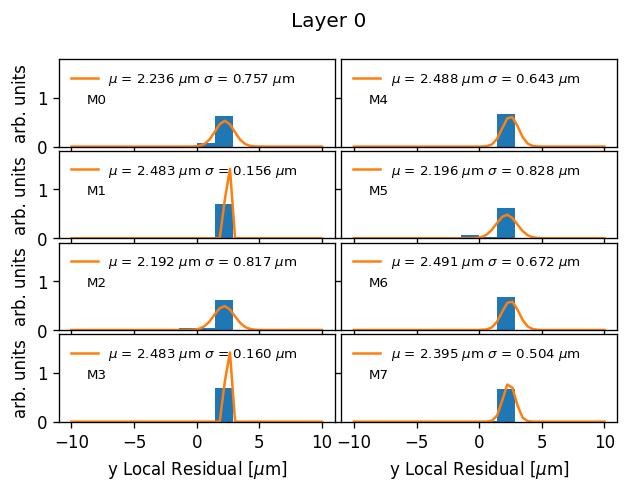

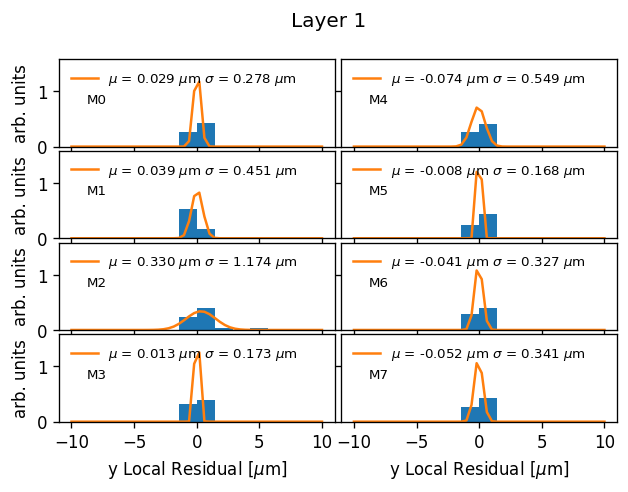

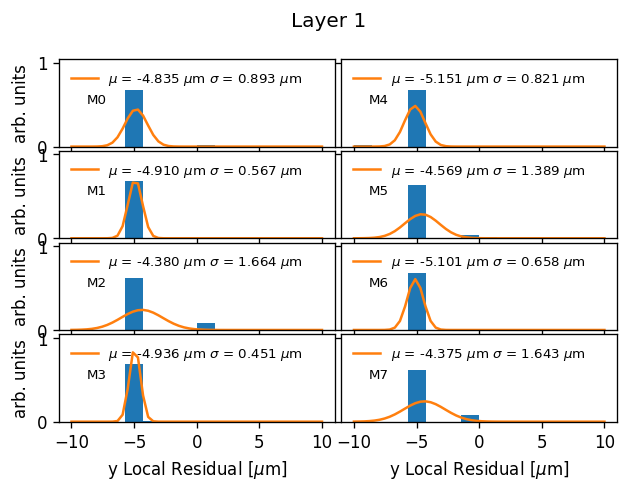

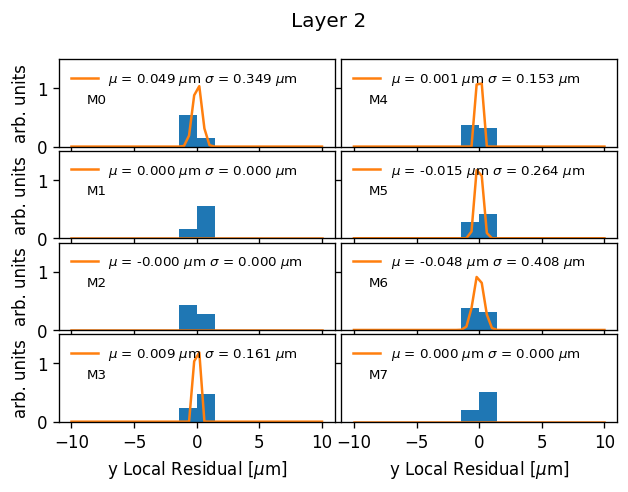

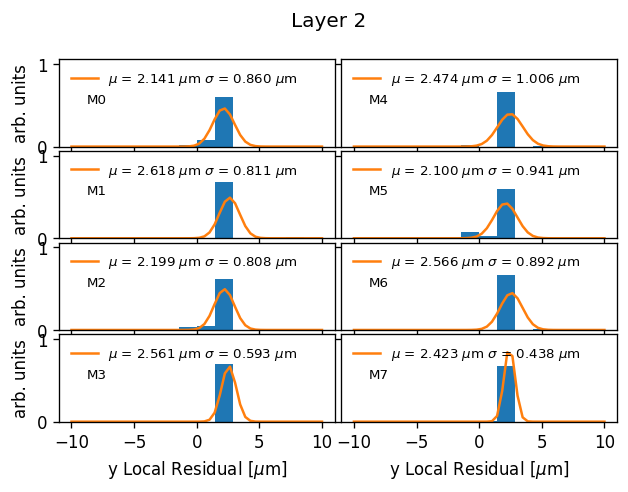

In [11]:
for L in range(3):
    plot_residual_per_module(study_it0, L, "y", None)
    plot_residual_per_module(study_it1, L, "y", None)

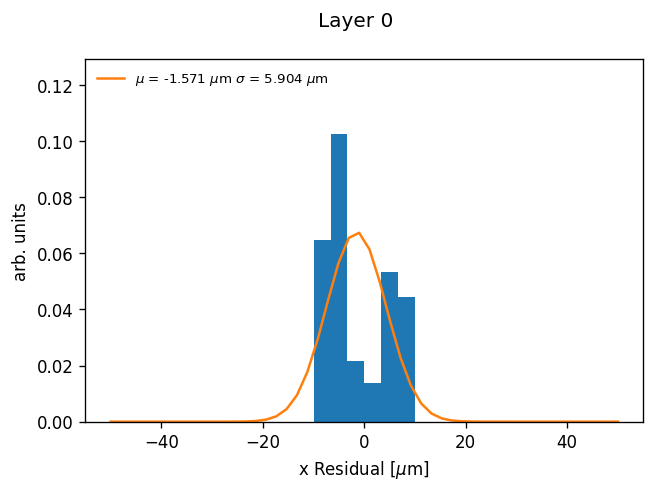

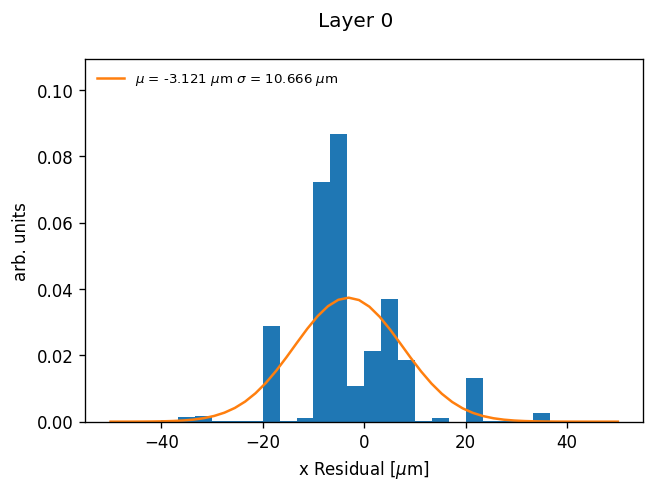

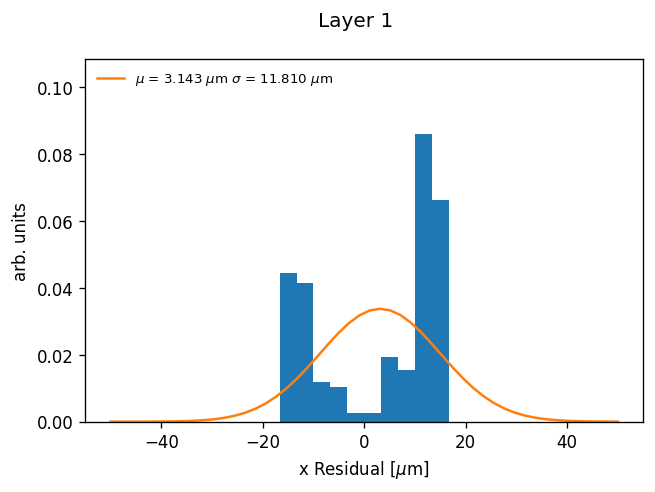

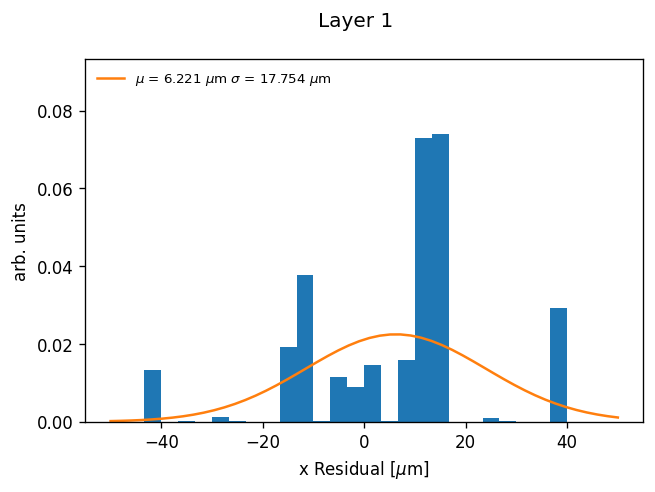

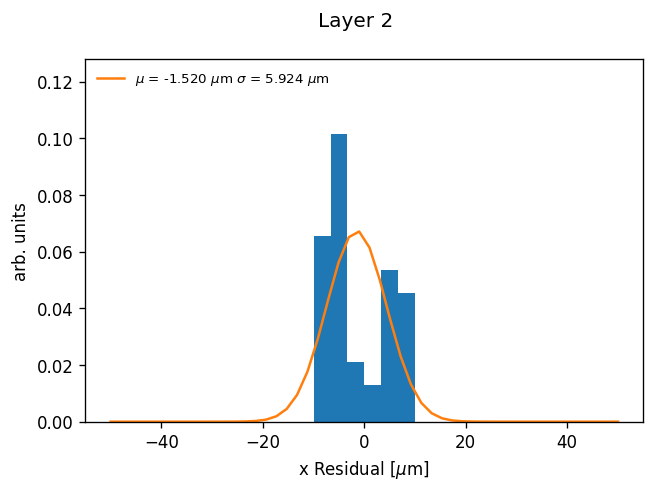

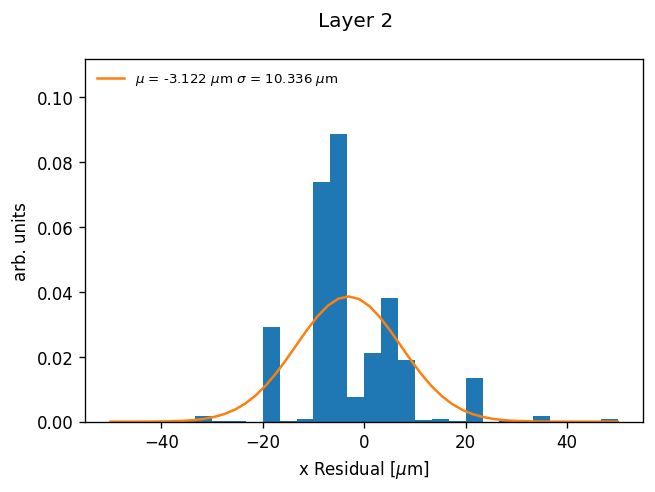

In [12]:
for L in range(3):
    plot_residual_per_layer(study_it0, L, "x", None)
    plot_residual_per_layer(study_it1, L, "x", None)

In [13]:
# Define here which data sample is used to determine alignment constants
study = study_it0

In [14]:
from alignment.monitoring import plot_chi2, plot_hit_position_per_module, plot_residual_per_module, plot_residual_per_layer
from alignment.equations import build_alignment_chi2_equation_module
from alignment.constants import runs
from copy import copy

In [15]:
t, M = build_alignment_chi2_equation_module(
    study[[
           "x0_local", "x1_local", "x2_local",
           "y0_local", "y1_local", "y2_local",
           "z0", "z1", "z2",
           "initial_track_my",  # xy flipped in local coordinates
           "initial_track_mx", 
           "initial_track_residual_x0_local", "initial_track_residual_x1_local", "initial_track_residual_x2_local",
           "initial_track_residual_y0_local", "initial_track_residual_y1_local", "initial_track_residual_y2_local", 
           "module0", "module1", "module2",
           "sigma_x0_local", "sigma_x1_local", "sigma_x2_local",
           "sigma_y0_local", "sigma_y1_local", "sigma_y2_local",
           "rho0_local", "rho1_local", "rho2_local",
       ]]
)

In [16]:
from alignment.equations import save_and_store_results_module, solve_alignment_chi2_equation, apply_soft_mode_cut_to_chi2_equation, fix_parameters_in_chi2_equation
from alignment.constants import RESCALING, runs
from alignment.monitoring import plot_matrix


def align(output_dir, t, M, soft_mode_cut, cutoff, fix):

    t, M = apply_soft_mode_cut_to_chi2_equation(t, M, soft_mode_cut=soft_mode_cut)
    t, M = fix_parameters_in_chi2_equation(t, M, fix=fix)

    plot_matrix(M, output_dir)

    a, Minv = solve_alignment_chi2_equation(t, M, output_dir, cutoff=cutoff, plot=True)
    return a, Minv


In [17]:
FIX = None
CUTOFF = 100
METEOROLOGY_alpha0_module = np.zeros(144)
METEOROLOGY_sigma0_module = np.array(8 * 3 * [1e-1, 1e-1, 1e-1, 2e-3, 2e-3, 2e-3]) / np.array(8 * 3 * [*RESCALING])
SOFT_MODE_CUT_module = (METEOROLOGY_alpha0_module, METEOROLOGY_sigma0_module)

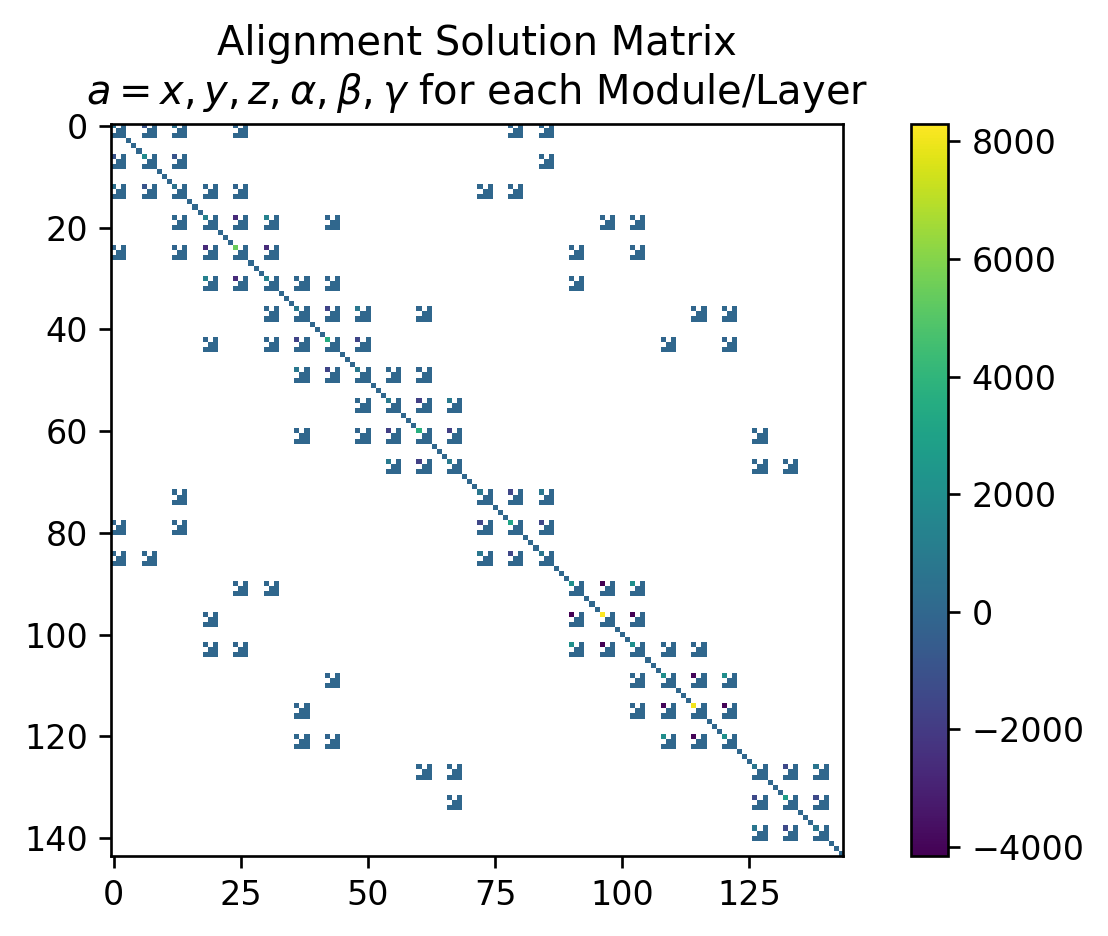

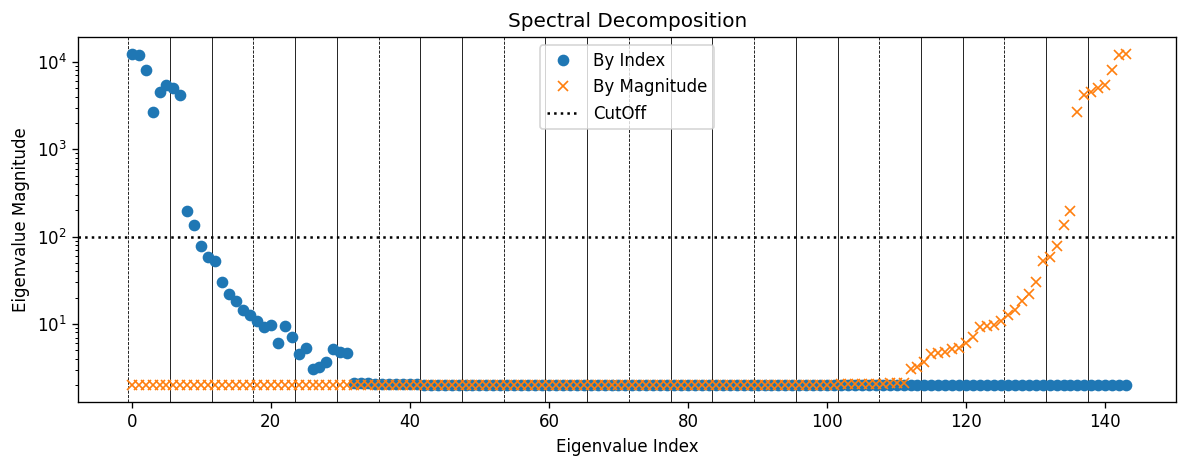

In [18]:
a, Minv = align(None, t, M, soft_mode_cut=SOFT_MODE_CUT_module, cutoff=CUTOFF, fix=FIX)

In [19]:
from uncertainties import unumpy as unp
from alignment.equations import module_index
from alignment.constants import result_cols

In [20]:
a *= np.array(3*8*[*RESCALING])
Minv *= np.array(3*8*[*RESCALING]) ** 2
MinvDiagonal = copy(Minv.diagonal())

result_table = pd.DataFrame({
    r"L0M0": unp.uarray(a[module_index(0, 0):module_index(0, 0)+6],  MinvDiagonal[module_index(0, 0):module_index(0, 0)+6] ** 0.5) * 1000,
    r"L0M1": unp.uarray(a[module_index(0, 1):module_index(0, 1)+6],  MinvDiagonal[module_index(0, 1):module_index(0, 1)+6] ** 0.5) * 1000,
    r"L0M2": unp.uarray(a[module_index(0, 2):module_index(0, 2)+6],  MinvDiagonal[module_index(0, 2):module_index(0, 2)+6] ** 0.5) * 1000,
    r"L0M3": unp.uarray(a[module_index(0, 3):module_index(0, 3)+6],  MinvDiagonal[module_index(0, 3):module_index(0, 3)+6] ** 0.5) * 1000,
    r"L0M4": unp.uarray(a[module_index(0, 4):module_index(0, 4)+6],  MinvDiagonal[module_index(0, 4):module_index(0, 4)+6] ** 0.5) * 1000,
    r"L0M5": unp.uarray(a[module_index(0, 5):module_index(0, 5)+6],  MinvDiagonal[module_index(0, 5):module_index(0, 5)+6] ** 0.5) * 1000,
    r"L0M6": unp.uarray(a[module_index(0, 6):module_index(0, 6)+6],  MinvDiagonal[module_index(0, 6):module_index(0, 6)+6] ** 0.5) * 1000,
    r"L0M7": unp.uarray(a[module_index(0, 7):module_index(0, 7)+6],  MinvDiagonal[module_index(0, 7):module_index(0, 7)+6] ** 0.5) * 1000,

    r"L1M0": unp.uarray(a[module_index(1, 0):module_index(1, 0)+6],  MinvDiagonal[module_index(1, 0):module_index(1, 0)+6] ** 0.5) * 1000,
    r"L1M1": unp.uarray(a[module_index(1, 1):module_index(1, 1)+6],  MinvDiagonal[module_index(1, 1):module_index(1, 1)+6] ** 0.5) * 1000,
    r"L1M2": unp.uarray(a[module_index(1, 2):module_index(1, 2)+6],  MinvDiagonal[module_index(1, 2):module_index(1, 2)+6] ** 0.5) * 1000,
    r"L1M3": unp.uarray(a[module_index(1, 3):module_index(1, 3)+6],  MinvDiagonal[module_index(1, 3):module_index(1, 3)+6] ** 0.5) * 1000,
    r"L1M4": unp.uarray(a[module_index(1, 4):module_index(1, 4)+6],  MinvDiagonal[module_index(1, 4):module_index(1, 4)+6] ** 0.5) * 1000,
    r"L1M5": unp.uarray(a[module_index(1, 5):module_index(1, 5)+6],  MinvDiagonal[module_index(1, 5):module_index(1, 5)+6] ** 0.5) * 1000,
    r"L1M6": unp.uarray(a[module_index(1, 6):module_index(1, 6)+6],  MinvDiagonal[module_index(1, 6):module_index(1, 6)+6] ** 0.5) * 1000,
    r"L1M7": unp.uarray(a[module_index(1, 7):module_index(1, 7)+6],  MinvDiagonal[module_index(1, 7):module_index(1, 7)+6] ** 0.5) * 1000,

    r"L2M0": unp.uarray(a[module_index(2, 0):module_index(2, 0)+6],  MinvDiagonal[module_index(2, 0):module_index(2, 0)+6] ** 0.5) * 1000,
    r"L2M1": unp.uarray(a[module_index(2, 1):module_index(2, 1)+6],  MinvDiagonal[module_index(2, 1):module_index(2, 1)+6] ** 0.5) * 1000,
    r"L2M2": unp.uarray(a[module_index(2, 2):module_index(2, 2)+6],  MinvDiagonal[module_index(2, 2):module_index(2, 2)+6] ** 0.5) * 1000,
    r"L2M3": unp.uarray(a[module_index(2, 3):module_index(2, 3)+6],  MinvDiagonal[module_index(2, 3):module_index(2, 3)+6] ** 0.5) * 1000,
    r"L2M4": unp.uarray(a[module_index(2, 4):module_index(2, 4)+6],  MinvDiagonal[module_index(2, 4):module_index(2, 4)+6] ** 0.5) * 1000,
    r"L2M5": unp.uarray(a[module_index(2, 5):module_index(2, 5)+6],  MinvDiagonal[module_index(2, 5):module_index(2, 5)+6] ** 0.5) * 1000,
    r"L2M6": unp.uarray(a[module_index(2, 6):module_index(2, 6)+6],  MinvDiagonal[module_index(2, 6):module_index(2, 6)+6] ** 0.5) * 1000,
    r"L2M7": unp.uarray(a[module_index(2, 7):module_index(2, 7)+6],  MinvDiagonal[module_index(2, 7):module_index(2, 7)+6] ** 0.5) * 1000,

}, index=result_cols).transpose()

In [21]:
# Results are in local coordinates!

In [22]:
result_table.applymap(lambda x: f"{x:.3f}")

,$x$ [$\mu m$],$y$ [$\mu m$],$z$ [$\mu m$],$\alpha$ [mrad],$\beta$ [mrad],$\gamma$ [mrad]
L0M0,3.621+/-0.984,-0.000+/-0.000,0.006+/-0.003,0.000+/-0,0.000+/-0,0.000+/-0
L0M1,9.344+/-3.572,0.000+/-0.000,0.042+/-0.016,0.000+/-0,0.000+/-0,0.000+/-0
L0M2,-0.057+/-2.836,-0.000+/-0.000,0.004+/-0.005,0.000+/-0,0.000+/-0,0.000+/-0
L0M3,-1.130+/-0.929,0.000+/-0.000,0.000+/-0.001,0.000+/-0,0.000+/-0,0.000+/-0
L0M4,0.938+/-0.611,0.000+/-0.000,0.003+/-0.002,0.000+/-0,0.000+/-0,0.000+/-0
L0M5,-4.912+/-0.603,0.000+/-0.000,-0.019+/-0.002,0.000+/-0,0.000+/-0,0.000+/-0
L0M6,-7.491+/-2.098,-0.000+/-0.000,-0.001+/-0.002,0.000+/-0,0.000+/-0,0.000+/-0
L0M7,-5.084+/-0.635,-0.000+/-0.000,-0.004+/-0.000,0.000+/-0,0.000+/-0,0.000+/-0
L1M0,-15.007+/-3.048,-0.000+/-0.000,-0.034+/-0.007,0.000+/-0,0.000+/-0,0.000+/-0
L1M1,-0.573+/-3.749,-0.000+/-0.000,-0.023+/-0.006,0.000+/-0,0.000+/-0,0.000+/-0


In [23]:
stations = [0]
layers = [0, 1, 2]
modules = [0, 1, 2, 3, 4, 5, 6, 7]

c = {}
for station in stations:
    for layer in layers:
        for module in modules:
            c[f"{station}{layer}{module}"] = [
                -(unp.nominal_values(result_table.transpose()[f"L{layer}M{module}"][0]) + 0) / 1000,  # mm
                -(unp.nominal_values(result_table.transpose()[f"L{layer}M{module}"][1]) + 0) / 1000,  # mm
                -(unp.nominal_values(result_table.transpose()[f"L{layer}M{module}"][2]) + 0) / 1000,  # mm
                -(unp.nominal_values(result_table.transpose()[f"L{layer}M{module}"][3]) + 0) / 1000,  # rad
                -(unp.nominal_values(result_table.transpose()[f"L{layer}M{module}"][4]) + 0) / 1000,  # rad
                -(unp.nominal_values(result_table.transpose()[f"L{layer}M{module}"][5]) + 0) / 1000,  # rad
            ]


In [24]:
with open(f'iteration0_data_constants.txt','w') as outfile:
    outfile.write(str(c))

In [41]:
c = {}
for station in stations:
    for layer in layers:
        for module in modules:
            c[f"{station}{layer}{module}"] = [
                0,  # mm
                0,  # mm
                0,  # mm
                0,  # rad
                0,  # rad
                -1e-3,  # rad
            ]


In [42]:
with open(f'neg_gamma_test.txt','w') as outfile:
    outfile.write(str(c))

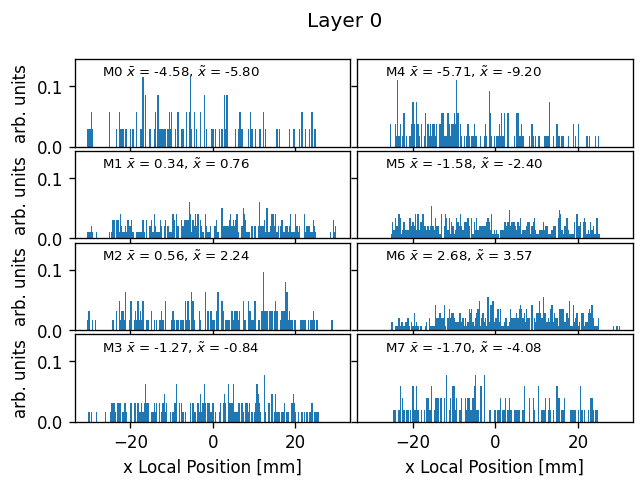

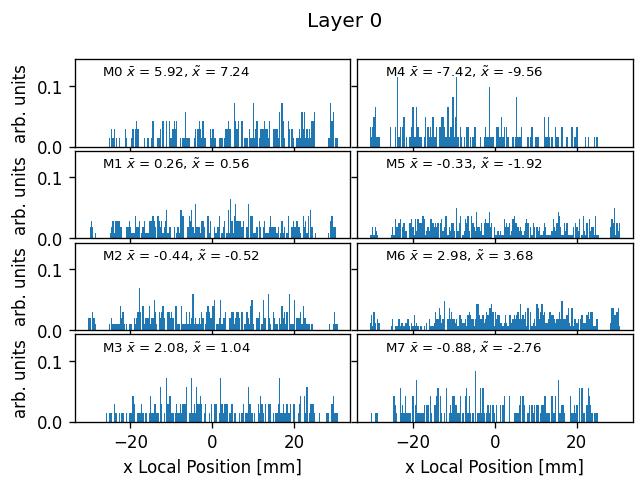

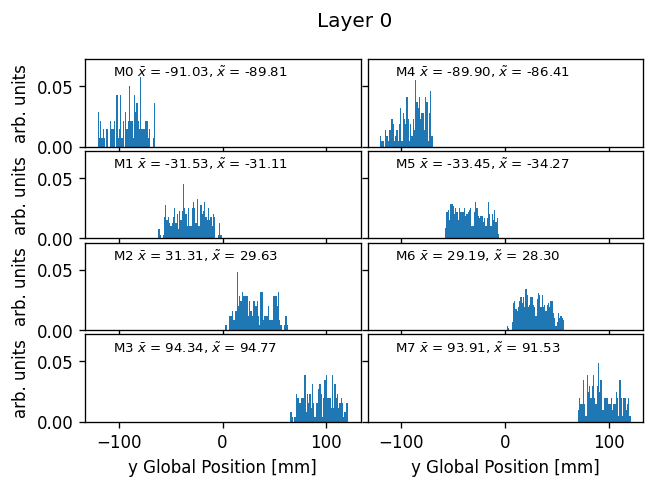

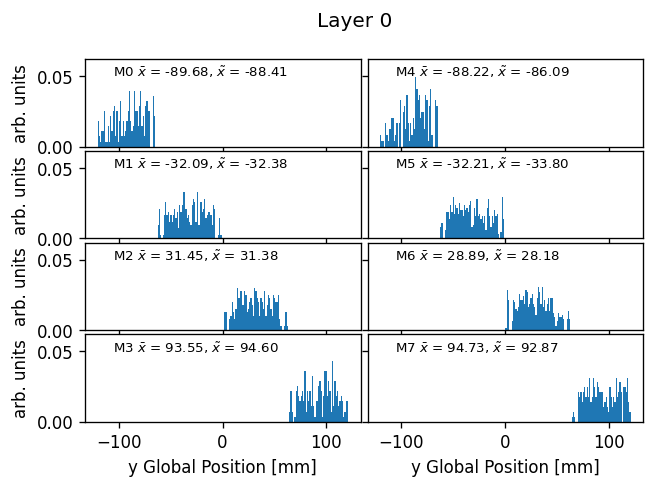

In [27]:
plot_hit_position_per_module(study_it0, 0, "x", output_dir=None, local=True)
plot_hit_position_per_module(study_it1, 0, "x", output_dir=None, local=True)

plot_hit_position_per_module(study_it0, 0, "y", output_dir=None, local=False)
plot_hit_position_per_module(study_it1, 0, "y", output_dir=None, local=False)

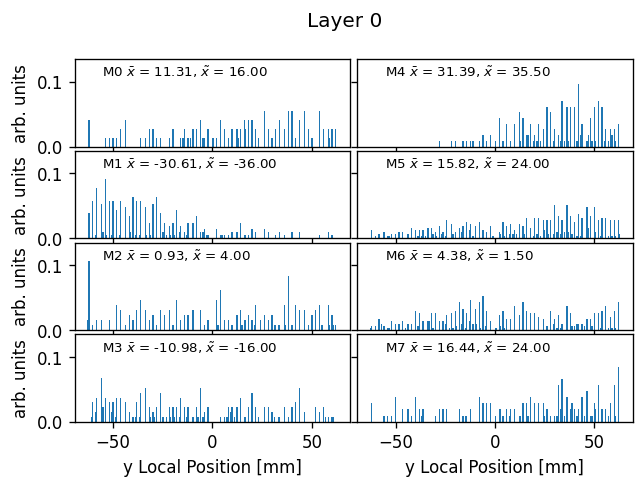

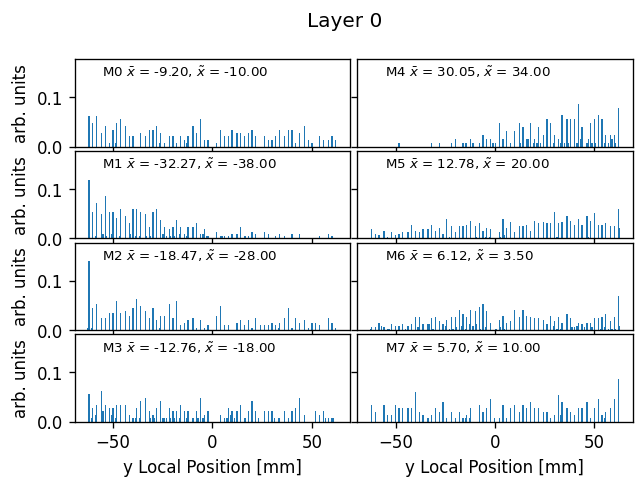

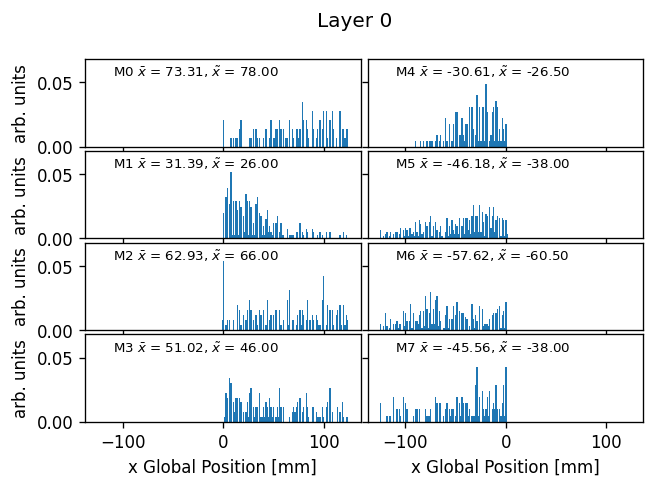

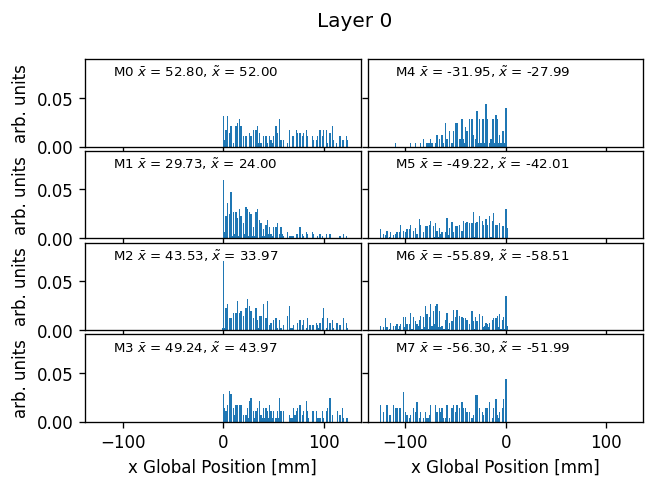

In [28]:
plot_hit_position_per_module(study_it0, 0, "y", output_dir=None, local=True)
plot_hit_position_per_module(study_it1, 0, "y", output_dir=None, local=True)

plot_hit_position_per_module(study_it0, 0, "x", output_dir=None, local=False)
plot_hit_position_per_module(study_it1, 0, "x", output_dir=None, local=False)

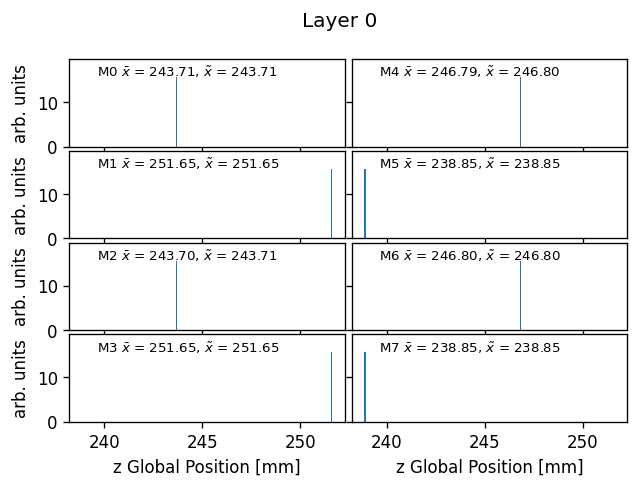

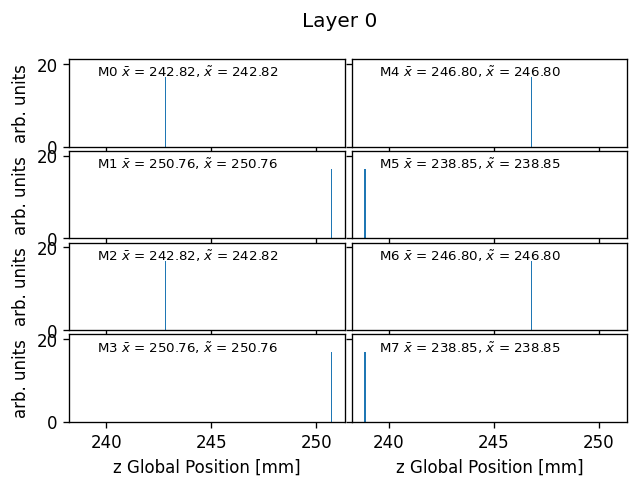

In [29]:
plot_hit_position_per_module(study_it0, 0, "z", output_dir=None, local=False)
plot_hit_position_per_module(study_it1, 0, "z", output_dir=None, local=False)

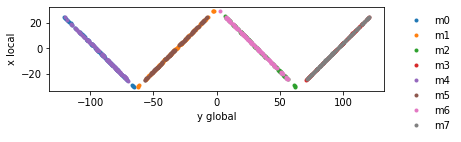

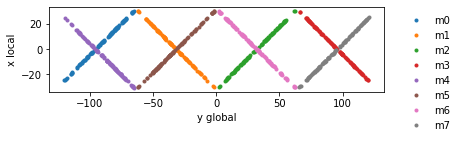

In [40]:
study = study_it0
plt.plot(study.query("module0 == 0").head(n=100).y0, study.query("module0 == 0").head(n=100).x0_local, marker=".", ls="", label="m0")
plt.plot(study.query("module0 == 1").head(n=100).y0, study.query("module0 == 1").head(n=100).x0_local, marker=".", ls="", label="m1")
plt.plot(study.query("module0 == 2").head(n=100).y0, study.query("module0 == 2").head(n=100).x0_local, marker=".", ls="", label="m2")
plt.plot(study.query("module0 == 3").head(n=100).y0, study.query("module0 == 3").head(n=100).x0_local, marker=".", ls="", label="m3")
plt.plot(study.query("module0 == 4").head(n=100).y0, study.query("module0 == 4").head(n=100).x0_local, marker=".", ls="", label="m4")
plt.plot(study.query("module0 == 5").head(n=100).y0, study.query("module0 == 5").head(n=100).x0_local, marker=".", ls="", label="m5")
plt.plot(study.query("module0 == 6").head(n=100).y0, study.query("module0 == 6").head(n=100).x0_local, marker=".", ls="", label="m6")
plt.plot(study.query("module0 == 7").head(n=100).y0, study.query("module0 == 7").head(n=100).x0_local, marker=".", ls="", label="m7")
plt.legend(frameon=False, bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylabel("x local")
plt.xlabel("y global")
plt.gca().set_aspect("equal")
plt.show()


study = study_it1
plt.plot(study.query("module0 == 0").head(n=100).y0, study.query("module0 == 0").head(n=100).x0_local, marker=".", ls="", label="m0")
plt.plot(study.query("module0 == 1").head(n=100).y0, study.query("module0 == 1").head(n=100).x0_local, marker=".", ls="", label="m1")
plt.plot(study.query("module0 == 2").head(n=100).y0, study.query("module0 == 2").head(n=100).x0_local, marker=".", ls="", label="m2")
plt.plot(study.query("module0 == 3").head(n=100).y0, study.query("module0 == 3").head(n=100).x0_local, marker=".", ls="", label="m3")
plt.plot(study.query("module0 == 4").head(n=100).y0, study.query("module0 == 4").head(n=100).x0_local, marker=".", ls="", label="m4")
plt.plot(study.query("module0 == 5").head(n=100).y0, study.query("module0 == 5").head(n=100).x0_local, marker=".", ls="", label="m5")
plt.plot(study.query("module0 == 6").head(n=100).y0, study.query("module0 == 6").head(n=100).x0_local, marker=".", ls="", label="m6")
plt.plot(study.query("module0 == 7").head(n=100).y0, study.query("module0 == 7").head(n=100).x0_local, marker=".", ls="", label="m7")
plt.legend(frameon=False, bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylabel("x local")
plt.xlabel("y global")
plt.gca().set_aspect("equal")
plt.show()


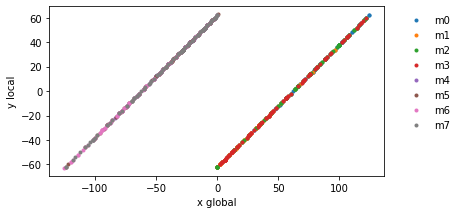

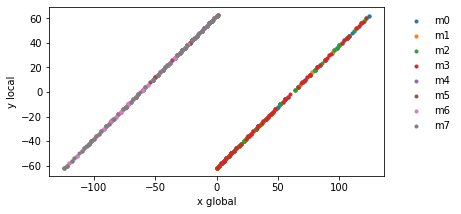

In [39]:
study = study_it0
plt.plot(study.query("module0 == 0").head(n=100).x0, study.query("module0 == 0").head(n=100).y0_local, marker=".", ls="", label="m0")
plt.plot(study.query("module0 == 1").head(n=100).x0, study.query("module0 == 1").head(n=100).y0_local, marker=".", ls="", label="m1")
plt.plot(study.query("module0 == 2").head(n=100).x0, study.query("module0 == 2").head(n=100).y0_local, marker=".", ls="", label="m2")
plt.plot(study.query("module0 == 3").head(n=100).x0, study.query("module0 == 3").head(n=100).y0_local, marker=".", ls="", label="m3")
plt.plot(study.query("module0 == 4").head(n=100).x0, study.query("module0 == 4").head(n=100).y0_local, marker=".", ls="", label="m4")
plt.plot(study.query("module0 == 5").head(n=100).x0, study.query("module0 == 5").head(n=100).y0_local, marker=".", ls="", label="m5")
plt.plot(study.query("module0 == 6").head(n=100).x0, study.query("module0 == 6").head(n=100).y0_local, marker=".", ls="", label="m6")
plt.plot(study.query("module0 == 7").head(n=100).x0, study.query("module0 == 7").head(n=100).y0_local, marker=".", ls="", label="m7")
plt.legend(frameon=False, bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylabel("y local")
plt.xlabel("x global")
plt.gca().set_aspect("equal")
plt.show()


study = study_it1
plt.plot(study.query("module0 == 0").head(n=100).x0, study.query("module0 == 0").head(n=100).y0_local, marker=".", ls="", label="m0")
plt.plot(study.query("module0 == 1").head(n=100).x0, study.query("module0 == 1").head(n=100).y0_local, marker=".", ls="", label="m1")
plt.plot(study.query("module0 == 2").head(n=100).x0, study.query("module0 == 2").head(n=100).y0_local, marker=".", ls="", label="m2")
plt.plot(study.query("module0 == 3").head(n=100).x0, study.query("module0 == 3").head(n=100).y0_local, marker=".", ls="", label="m3")
plt.plot(study.query("module0 == 4").head(n=100).x0, study.query("module0 == 4").head(n=100).y0_local, marker=".", ls="", label="m4")
plt.plot(study.query("module0 == 5").head(n=100).x0, study.query("module0 == 5").head(n=100).y0_local, marker=".", ls="", label="m5")
plt.plot(study.query("module0 == 6").head(n=100).x0, study.query("module0 == 6").head(n=100).y0_local, marker=".", ls="", label="m6")
plt.plot(study.query("module0 == 7").head(n=100).x0, study.query("module0 == 7").head(n=100).y0_local, marker=".", ls="", label="m7")
plt.legend(frameon=False, bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylabel("y local")
plt.xlabel("x global")
plt.gca().set_aspect("equal")
plt.show()


In [37]:
assert False

AssertionError: 

In [ ]:
study = study_it0
plt.plot(study.query("module0 == 0").head(n=100).y1, study.query("module0 == 0").head(n=100).x1_local, marker=".", ls="", label="m0")
plt.plot(study.query("module0 == 1").head(n=100).y1, study.query("module0 == 1").head(n=100).x1_local, marker=".", ls="", label="m1")
plt.plot(study.query("module0 == 2").head(n=100).y1, study.query("module0 == 2").head(n=100).x1_local, marker=".", ls="", label="m2")
plt.plot(study.query("module0 == 3").head(n=100).y1, study.query("module0 == 3").head(n=100).x1_local, marker=".", ls="", label="m3")
plt.plot(study.query("module0 == 4").head(n=100).y1, study.query("module0 == 4").head(n=100).x1_local, marker=".", ls="", label="m4")
plt.plot(study.query("module0 == 5").head(n=100).y1, study.query("module0 == 5").head(n=100).x1_local, marker=".", ls="", label="m5")
plt.plot(study.query("module0 == 6").head(n=100).y1, study.query("module0 == 6").head(n=100).x1_local, marker=".", ls="", label="m6")
plt.plot(study.query("module0 == 7").head(n=100).y1, study.query("module0 == 7").head(n=100).x1_local, marker=".", ls="", label="m7")
plt.legend(frameon=False, bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylabel("x local")
plt.xlabel("y global")
plt.gca().set_aspect("equal")
plt.show()


study = study_it1
plt.plot(study.query("module0 == 0").head(n=100).y1, study.query("module0 == 0").head(n=100).x1_local, marker=".", ls="", label="m0")
plt.plot(study.query("module0 == 1").head(n=100).y1, study.query("module0 == 1").head(n=100).x1_local, marker=".", ls="", label="m1")
plt.plot(study.query("module0 == 2").head(n=100).y1, study.query("module0 == 2").head(n=100).x1_local, marker=".", ls="", label="m2")
plt.plot(study.query("module0 == 3").head(n=100).y1, study.query("module0 == 3").head(n=100).x1_local, marker=".", ls="", label="m3")
plt.plot(study.query("module0 == 4").head(n=100).y1, study.query("module0 == 4").head(n=100).x1_local, marker=".", ls="", label="m4")
plt.plot(study.query("module0 == 5").head(n=100).y1, study.query("module0 == 5").head(n=100).x1_local, marker=".", ls="", label="m5")
plt.plot(study.query("module0 == 6").head(n=100).y1, study.query("module0 == 6").head(n=100).x1_local, marker=".", ls="", label="m6")
plt.plot(study.query("module0 == 7").head(n=100).y1, study.query("module0 == 7").head(n=100).x1_local, marker=".", ls="", label="m7")
plt.legend(frameon=False, bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylabel("x local")
plt.xlabel("y global")
plt.gca().set_aspect("equal")
plt.show()


In [ ]:
study = study_it0
plt.plot(study.query("module0 == 0").head(n=100).y2, study.query("module0 == 0").head(n=100).x2_local, marker=".", ls="", label="m0")
plt.plot(study.query("module0 == 1").head(n=100).y2, study.query("module0 == 1").head(n=100).x2_local, marker=".", ls="", label="m1")
plt.plot(study.query("module0 == 2").head(n=100).y2, study.query("module0 == 2").head(n=100).x2_local, marker=".", ls="", label="m2")
plt.plot(study.query("module0 == 3").head(n=100).y2, study.query("module0 == 3").head(n=100).x2_local, marker=".", ls="", label="m3")
plt.plot(study.query("module0 == 4").head(n=100).y2, study.query("module0 == 4").head(n=100).x2_local, marker=".", ls="", label="m4")
plt.plot(study.query("module0 == 5").head(n=100).y2, study.query("module0 == 5").head(n=100).x2_local, marker=".", ls="", label="m5")
plt.plot(study.query("module0 == 6").head(n=100).y2, study.query("module0 == 6").head(n=100).x2_local, marker=".", ls="", label="m6")
plt.plot(study.query("module0 == 7").head(n=100).y2, study.query("module0 == 7").head(n=100).x2_local, marker=".", ls="", label="m7")
plt.legend(frameon=False, bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylabel("x local")
plt.xlabel("y global")
plt.gca().set_aspect("equal")
plt.show()


study = study_it1
plt.plot(study.query("module0 == 0").head(n=100).y2, study.query("module0 == 0").head(n=100).x2_local, marker=".", ls="", label="m0")
plt.plot(study.query("module0 == 1").head(n=100).y2, study.query("module0 == 1").head(n=100).x2_local, marker=".", ls="", label="m1")
plt.plot(study.query("module0 == 2").head(n=100).y2, study.query("module0 == 2").head(n=100).x2_local, marker=".", ls="", label="m2")
plt.plot(study.query("module0 == 3").head(n=100).y2, study.query("module0 == 3").head(n=100).x2_local, marker=".", ls="", label="m3")
plt.plot(study.query("module0 == 4").head(n=100).y2, study.query("module0 == 4").head(n=100).x2_local, marker=".", ls="", label="m4")
plt.plot(study.query("module0 == 5").head(n=100).y2, study.query("module0 == 5").head(n=100).x2_local, marker=".", ls="", label="m5")
plt.plot(study.query("module0 == 6").head(n=100).y2, study.query("module0 == 6").head(n=100).x2_local, marker=".", ls="", label="m6")
plt.plot(study.query("module0 == 7").head(n=100).y2, study.query("module0 == 7").head(n=100).x2_local, marker=".", ls="", label="m7")
plt.legend(frameon=False, bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylabel("x local")
plt.xlabel("y global")
plt.gca().set_aspect("equal")
plt.show()
